# Lab 06: PVT EOS AND EXOPLANETS

S.T. Stewart<br>
sts@ucdavis.edu<br>
May 12, 2020

## Model Planets and the Exoplanet Mass-Radius Diagram

Our model planets will be comprised of two layers: a silicate mantle and iron core. We will begin with very primitive models and improve them using pressure-volume-temperature EOS models.

Here, we focus on forward-modeling a planetary structure to compare to available information. This is a useful approach when learning to develop your intuition and understanding of concepts. 

This exercise assumes you have experience reading in data, making plots, writing data to a file, and saving plots in different formats in a Jupyter notebook.

We will use the calculation of Earth's interior structure as one example and compare the calculation to the Preliminary Reference Earth Model (PREM).

In [1]:
# This is a code cell
# In code cells, # denotes the start of comments

# Python is a computer language that is experiencing rapid development; sometimes features change or disappear
# recording the version information makes sure that your calculations are reproducible
# Record the verion information for these calculations for posterity
# Not all of these packages should be imported in total, 
# so they are deleted after the version information is extracted
import platform
print('python version: ',platform.python_version())
del platform
import matplotlib
print('matplotlib version: ', matplotlib.__version__)
del matplotlib
import numpy
print('numpy version: ', numpy.__version__)
del numpy
import scipy
print('scipy version: ', scipy.__version__)
del scipy

# Import only the python libraries that we need 
import matplotlib.pyplot as plt
#import matplotlib.cm as cm
import numpy as np
from scipy.interpolate import interp1d
#from mpl_toolkits.axes_grid1 import make_axes_locatable

#plt.rcParams["figure.figsize"] = (20,18) # default figure size in inches for our 2x2 subplots

python version:  3.6.10
matplotlib version:  3.1.2
numpy version:  1.18.1
scipy version:  1.4.1


# INTRODUCTION

In [2]:
# Declare some standard variables to be consistent with the PREM model we will be using
# We will use MKS units
G       = 6.67E-11 # Gravitational constant  m3/kg/s2
Mearth  = 5.972E24 # Earth's mass kg
Rearth  = 6371.E3  # Earth's radius m (from PREM)
Rcmb    = 3480000. # CMB radius in m (from PREM)
Iearth  = 0.3308*Mearth*Rearth**2 # Earth's moment of inertia kg m2 from https://nssdc.gsfc.nasa.gov/planetary/factsheet/earthfact.html
Ricb    = 1221500. # inner core radius in m (from PREM)
Tmantle = 1700. # K potential temperature of the mantle
Tcmb    = 4500. # K temperature at the core-mantle-boundary

sfont=15 # for plots

## NASA Exoplanet Archive
https://exoplanetarchive.ipac.caltech.edu <br>
https://exoplanetarchive.ipac.caltech.edu/exoplanetplots/ <br>

<img src="exo_massradius_cb.png" width=600><p>
<img src="exo_densrad_cb.png" width=600><p>



The shape of the array Exoplanets:  (511, 3)
[2.6   0.066 0.522]


(0, 20)

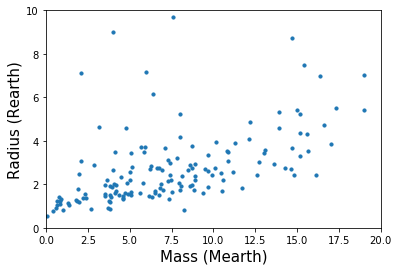

In [3]:
# read in Exoplanet data. Filtered for planets with both masses and radii.

# data filtered for planets with values for density, mass and radius
Exoplanets_filename='planets_filtered2.csv' # we love long, readable variable names!

# reading in density (g/cm3), Mass (Mearth), Radius (Rearth)
Exoplanets = np.loadtxt(Exoplanets_filename,delimiter=',',skiprows=56,usecols=(1,2,3))

# Let's examine this variable now
print('The shape of the array Exoplanets: ',Exoplanets.shape)
print(Exoplanets[0,:])

plt.scatter(Exoplanets[:,1],Exoplanets[:,2],s=10,marker='o')
plt.xlabel('Mass (Mearth)',size=sfont)
plt.ylabel('Radius (Rearth)',size=sfont)
plt.ylim(0,10)
plt.xlim(0,20)

## We will use PREM as a reference and input for our calculations

PREM is a one-dimensional average structure model for the Earth developed from seismic data. The original reference is:<br>
<b>Dziewonski, A. M., and D. L. Anderson. 1981. "Preliminary reference Earth model." Phys. Earth Plan. Int. 25:297-356.</b>

The 1D model has been updated by Panning and Romanowicz (2006). Download the Modified PREM model from the <a href="http://ds.iris.edu/spud/earthmodel/9785674">IRIS web site</a>.

There are three different data formats. Download the "The model in comma separated value (CSV) IDV file format". I like this file format because it includes the units in the file header. The file name is PREM500_IDV.csv

You can open the file in the Jupyter environment by going back to the file browser. Take a moment now and open the PREM file in your web browser.

The beginning of the file is:<br>
`
(index -> (radius,density,Vpv,Vsv,Q-kappa,Q-mu,Vph,Vsh,eta))
radius[unit="m"],density[unit="kg/m^3"],Vpv[unit="m/s"],Vsv[unit="m/s"],Q-kappa[unit=""],Q-mu[unit=""],Vph[unit="m/s"],Vsh[unit="m/s"],eta[unit=""]
`


This header is followed by comma separated columns of numbers. The first column is radius of the Earth with zero at the center. We will use only the vertical components of the p and s wave velocities. If you compare the vertical and horizontal values, you will see that they only vary in the lithosphere, and we will be neglecting these details in this exercise.

# DEFINE CLASSES AND FUNCTIONS

Python class objects can contain data as well as functions:

In [4]:
# make a class to hold the PREM model
# the class also holds derived variables related to the radial structure of the planet (gravity; pressure)
class PREMclass:
    """Class to hold PREM data."""   # this is a documentation string for this class
    def __init__(self): # self is the default name of the object for internal referencing of the variables in the class
        """A function to initialize the class object.""" # this is a documentation string for this function
        self.NR       = 0                    # number of radius points; initialize with no points
        self.radius   = np.zeros(self.NR) 
        self.density  = np.zeros(self.NR)   
        self.pwavevel = np.zeros(self.NR)    # using vertical components of p and s waves
        self.swavevel = np.zeros(self.NR)
        self.pressure = np.zeros(self.NR)    # prepare to populate this structure with derived variables
        self.gravity  = np.zeros(self.NR)
        self.dr       = np.zeros(self.NR)
        self.massperlayer = np.zeros(self.NR)
        self.K            = np.zeros(self.NR) # Bulk modulus Pa
        self.G            = np.zeros(self.NR) # Shear modulus Pa
        self.phi          = np.zeros(self.NR) # Adams-Williamson parameter
        self.M = 0 # total mass
        self.I = 0 # moment of inertia C/MR2
        # not going to use all the variables in the PREM file
        self.units = '' # I like to keep a text note in a structure about the units
        
# make a class to hold the model planet: same class for the PREM data and our model planet
# the class also holds derived variables related to the radial structure of the planet (gravity; pressure)
class PLANETclass:
    """Class to hold MODEL PLANET data."""   # this is a documentation string for this class
    def __init__(self): # self is the default name of the object for internal referencing of the variables in the class
        """A function to initialize the class object.""" # this is a documentation string for this function
        self.NR       = 0                   # number of radius points in the planet; initialize with no points
        self.radius   = np.zeros(self.NR) 
        self.density  = np.zeros(self.NR)   
        self.temp     = np.zeros(self.NR)   
        self.massperlayer = np.zeros(self.NR)
        self.volperlayer = np.zeros(self.NR)
        self.cumulativemass = np.zeros(self.NR)
        self.pressure  = np.zeros(self.NR)    # prepare to populate this structure with derived variables
        self.gravity   = np.zeros(self.NR)
        self.pwavevel  = np.zeros(self.NR)    # p and s waves
        self.swavevel  = np.zeros(self.NR)
        self.dr        = np.zeros(self.NR)
        self.K         = np.zeros(self.NR) # Bulk modulus Pa
        self.G         = np.zeros(self.NR) # Shear modulus Pa
        self.alpha     = np.zeros(self.NR) # thermal expansion
        self.cp        = np.zeros(self.NR) # heat capacity
        self.gamma     = np.zeros(self.NR) # Gruneisen parameter
        self.Mcore = 0 # core mass
        self.M = 0 # total mass
        self.I = 0 # moment of inertia C/MR2
        self.planetradius = 0 # km
        self.coreradius = 0 # km
        # not going to use all the variables in the PREM file
        self.units = '' # I like to keep a text note in a structure about the units
        
    def makeinit(self, NR, planetradius, coreradius): # self is the default name of the object for internal referencing of the variables in the class
        """A function to initialize the planet radial profile.""" # this is a documentation string for this function

        planetradius=planetradius*1000.# km->m
        coreradius=coreradius*1000.# km->m

        # now loop through the PLANET and populate the rest of the variables
        self.NR = NR
        self.density = np.zeros(NR)
        self.temperature = np.zeros(NR)
        self.radius = np.linspace(0,planetradius,NR)
        self.planetradius = planetradius*1000. 
        self.coreradius = coreradius
        self.cp = np.zeros(NR)
        self.alpha = np.zeros(NR)

        for ir in np.arange(0,NR):
            if (self.radius[ir] <= self.coreradius):
                self.density[ir]     = 11000.0 # kg/m3
                self.temperature[ir] = 5000. # K
                self.cp[ir] = 800. # J/K/kg
                self.alpha[ir] = 1.E-5 # 1/K
            if (self.radius[ir] > self.coreradius):
                self.density[ir]     = 4000.0 # kg/m3
                self.temperature[ir] = 1700.0    # K          
                self.cp[ir] = 1000. # J/K/kg
                self.alpha[ir] = 1.E-5 # 1/K

        self.gravity = np.zeros(NR)
        self.pressure = np.zeros(NR)
        self.dr = np.zeros(NR)
        self.massperlayer = np.zeros(NR)
        self.M = 0.
        self.Mcore = 0.
        for i in range(1,self.NR,1): # loop from center to surface
            self.dr[i]           = self.radius[i]-self.radius[i-1]
            self.massperlayer[i] = 4.*3.14159*self.density[i-1]*self.dr[i]*self.radius[i]**2
            self.gravity[i]      = G*np.sum(self.massperlayer[0:i])/self.radius[i]/self.radius[i]
            if self.radius[i] < self.coreradius:
                self.Mcore += self.massperlayer[i]
        for i in range(self.NR-2,0,-1): # loop from surface to center
            self.pressure[i]     = self.pressure[i+1]+self.density[i]*self.gravity[i]*self.dr[i]
        # for aesthetic reasons, enter the central pressure value in the array
        self.pressure[0]=self.pressure[1]
        # calculate total mass
        self.M = np.sum(self.massperlayer)
        # calculate moment of inertia
        for i in range(1,self.NR,1): # loop from center to surface
            self.I += (2/3)*self.massperlayer[i]*self.radius[i]**2
        self.I = self.I/(self.M*np.max(self.radius)**2)

    def plotplanet(self):
        # Now let's make some plots of the planet
        sfont=15 # I like to set the size of my fonts

        # make 4 plots to show the different variables in the structure
        fig, ([ax0, ax1], [ax2, ax3])= plt.subplots(ncols=2,nrows=2,figsize=(16,12))
        plt.subplots_adjust(wspace=1)

        # first subplot: density vs. radius
        # change units to g/cm3 and 1000 km
        ax0.plot(self.density/1.E3,self.radius/1.E6,'-',label='density')
        #ax0.set_ylim(0.,7)
        #ax0.set_xlim(0,15.)
        ax0.set_xlabel('Density (g/cm$^3$)',size=sfont)
        ax0.set_ylabel('Radius (1000 km)',size=sfont)
        ax0.set_title('Total mass (Mearth)='+str(self.M/Mearth),size=sfont)
        ax0.tick_params(labelsize=sfont)
        #ax0.legend(fontsize=sfont-5)

        # second subplot: p-wave, s-wave vels vs. radius
        # change units to km/s and 1000 km
        ax1.plot(self.radius/1.e6,self.temperature)
        #ax1.set_xlim(0.,7)
        #ax1.set_xlim(0,15.)
        ax1.set_ylabel('Temperature (K)',size=sfont)
        ax1.set_xlabel('Radius (1000 km)',size=sfont)
        ax1.set_title('Mcore/Mplanet='+str(self.Mcore/self.M),size=sfont)
        ax1.tick_params(labelsize=sfont)
        #ax1.legend(fontsize=sfont-5)

        # third subplot: gravitational acceleration vs. radius
        # change units to 1000 km
        ax2.plot(self.gravity,self.radius/1.E6,'-',label='gravity')
        #ax2.set_ylim(0.,7)
        ax2.set_xlabel('Gravitational acceleration (m/s$^2$)',size=sfont)
        ax2.set_ylabel('Radius (1000 km)',size=sfont)
        ax2.tick_params(labelsize=sfont)
        #ax2.legend(fontsize=sfont-5)

        # fourth subplot: pressure vs. radius
        # change units to GPa and 1000 km
        ax3.plot(self.pressure/1.e9,self.radius/1.E6,'-',label='pressure')
        #ax3.set_ylim(0.,7)
        ax3.set_xlabel('Pressure (GPa)',size=sfont)
        ax3.set_ylabel('Radius (1000 km)',size=sfont)
        ax3.tick_params(labelsize=sfont)
        #ax3.legend(fontsize=sfont-5)


        # this command adjusts the white space around the plots
        plt.tight_layout(pad=1.,w_pad=1.,h_pad=1.0)
        #plt.savefig('MYPLANET-plot.pdf', format='pdf', dpi=300,transparent=True)

    def MurnaghanEOS(self,EOSmantle, EOScore):
        """A function to modify radial profile with Murnaghan Isentropic EOS. Must run makeinit first.""" # this is a documentation string for this function
        # EOS parameters: [rho0,Ks0,dKsdP,T0] in [kg/m3, Pa, -, K]
        # NR, planetradius, coreradius are inherited from makeinit
        # pressure, gravity, temperature are pre-populated and will be updated iteratively

        Mlast = self.M*20.
        for iloop in np.arange(15):
            # now loop through the PLANET and update the density variable using the Murnaghan EOS
            for ir in np.arange(0,NR):
                if (self.radius[ir] <= self.coreradius):
                    self.density[ir]     = EOScore[0]*pow((1.0+self.pressure[ir]*(EOScore[2]/EOScore[1])),1./EOScore[2])
                if (self.radius[ir] > self.coreradius):
                    self.density[ir]     = EOSmantle[0]*pow((1.0+self.pressure[ir]*(EOSmantle[2]/EOSmantle[1])),1./EOSmantle[2])

            self.M = 0.
            self.Mcore = 0.
            for i in range(1,self.NR,1): # loop from center to surface
                self.dr[i]           = self.radius[i]-self.radius[i-1]
                self.massperlayer[i] = 4.*3.14159*self.density[i-1]*self.dr[i]*self.radius[i]**2
                self.gravity[i]      = G*np.sum(self.massperlayer[0:i])/self.radius[i]/self.radius[i]
                if self.radius[i] < self.coreradius:
                    self.Mcore += self.massperlayer[i]
            self.temperature[NR-1] = EOSmantle[3] # mantle potential temperature
            firstcore=0
            for i in range(self.NR-2,0,-1): # loop from surface to center
                self.pressure[i]     = self.pressure[i+1]+self.density[i]*self.gravity[i]*self.dr[i]
                if (self.radius[i] <= self.coreradius):
                    if (firstcore == 0):
                        self.temperature[i] = EOScore[3] # CMB temperature
                        firstcore=1
                    else:
                        self.temperature[i] = self.temperature[i+1]+self.alpha[i]*self.gravity[i]*self.temperature[i+1]/self.cp[i]*self.dr[i]
                if (self.radius[i] > self.coreradius):
                    self.temperature[i] = self.temperature[i+1]+self.alpha[i]*self.gravity[i]*self.temperature[i+1]/self.cp[i]*self.dr[i]

            # for aesthetic reasons, enter the central pressure and temperature value in the array
            self.pressure[0]=self.pressure[1]
            self.temperature[0]=self.temperature[1]
            # calculate total mass
            self.M = np.sum(self.massperlayer)
            # calculate moment of inertia
            for i in range(1,self.NR,1): # loop from center to surface
                self.I += (2/3)*self.massperlayer[i]*self.radius[i]**2
            self.I = self.I/(self.M*np.max(self.radius)**2)
            
            #print(iloop, self.M, self.Mcore)
            if (abs(Mlast-self.M)/self.M < 0.001):
                break
            Mlast = self.M

        

In [5]:
# READ IN PREM FOR LATER
PREM = PREMclass()
PREM_filename='PREM500_IDV.csv'
# Classes have a whole set of special built in objects
#help(PREM)
# note that the comments in the class definition are printed by help.

# read the data into the class parameters
PREM.radius = np.loadtxt(PREM_filename,delimiter=',',skiprows=2,usecols=[0]) # radius in m
PREM.density = np.loadtxt(PREM_filename,delimiter=',',skiprows=2,usecols=[1]) # density in kg/m3
PREM.pwavevel = np.loadtxt(PREM_filename,delimiter=',',skiprows=2,usecols=[2]) # p-wave velocity m/s vertical component
PREM.swavevel = np.loadtxt(PREM_filename,delimiter=',',skiprows=2,usecols=[3]) # s-wave velocity m/s vertical component
PREM.NR = len(PREM.radius) # number of radius points
# I like to put the units in the structure so I can easily remind myself and double check units while using these data
PREM.units = 'radius (m), density (kg/m3), pwavevel (m/s), swavevel (m/s), pressure (Pa), gravity (m/s2), dr (m), massperlayer (kg), K (Pa), G (Pa), phi (m2/s2), M (kg), I (M/R2)'

# now loop through the PREM data and populate the rest of the variables
PREM.gravity = np.zeros(PREM.NR)
PREM.pressure = np.zeros(PREM.NR)
PREM.dr = np.zeros(PREM.NR)
PREM.massperlayer = np.zeros(PREM.NR)
for i in range(1,PREM.NR,1): # loop from center to surface
    PREM.dr[i]           = PREM.radius[i]-PREM.radius[i-1]
    PREM.massperlayer[i] = 4.*3.14159*PREM.density[i-1]*PREM.dr[i]*PREM.radius[i]**2
    PREM.gravity[i]      = G*np.sum(PREM.massperlayer[0:i])/PREM.radius[i]/PREM.radius[i]
for i in range(PREM.NR-2,0,-1): # loop from surface to center
    PREM.pressure[i]     = PREM.pressure[i+1]+PREM.density[i]*PREM.gravity[i]*PREM.dr[i]
# for aesthetic reasons, enter the central pressure value in the array
PREM.pressure[0]=PREM.pressure[1]
# calculate total mass
PREM.M = np.sum(PREM.massperlayer)
# calculate moment of inertia
for i in range(1,PREM.NR,1): # loop from center to surface
    PREM.I += (2/3)*PREM.massperlayer[i]*PREM.radius[i]**2
PREM.I = PREM.I/(PREM.M*np.max(PREM.radius)**2)

print('Total mass (Mearth)=',PREM.M/Mearth)
print('Moment of inertia (C/MR2)=',PREM.I)

print('The shape of the radius array: ',PREM.radius.shape)
print('The first 10 values in radius: ',PREM.radius[0:10])
print('Units: ',PREM.units)

# Take a moment to inspect the PREM structure, print PREM.NR, print more values, etc.

Total mass (Mearth)= 1.004603061555901
Moment of inertia (C/MR2)= 0.33147240875757783
The shape of the radius array:  (504,)
The first 10 values in radius:  [     0.  12858.  25716.  38574.  51432.  64289.  77147.  90005. 102863.
 115721.]
Units:  radius (m), density (kg/m3), pwavevel (m/s), swavevel (m/s), pressure (Pa), gravity (m/s2), dr (m), massperlayer (kg), K (Pa), G (Pa), phi (m2/s2), M (kg), I (M/R2)


# Part 1: Initialize Constant-Density Two-Layer Planets

Just to get started with calculated Mass-Radius relationships, we will begin by making a place-holder initial planetary profile.

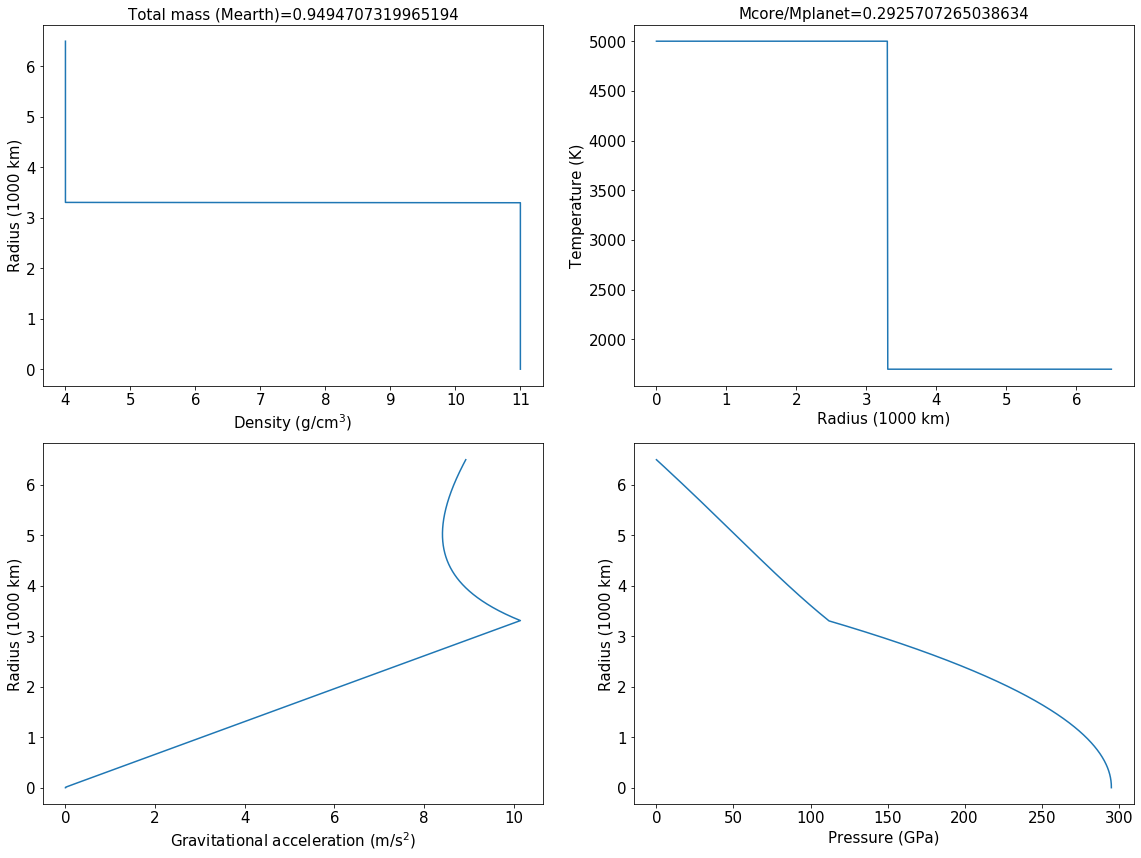

In [6]:
MYPLANET = PLANETclass()
MYPLANET.makeinit(1000,6500.,3300.) # Num radial points, radius of the planet (km), radius of core (km)
MYPLANET.plotplanet()
#print(MYPLANET.pressure)

## Make a mass-radius diagram with the 'initialized' planets

(0.0, 1.0, 0.0, 1.0)

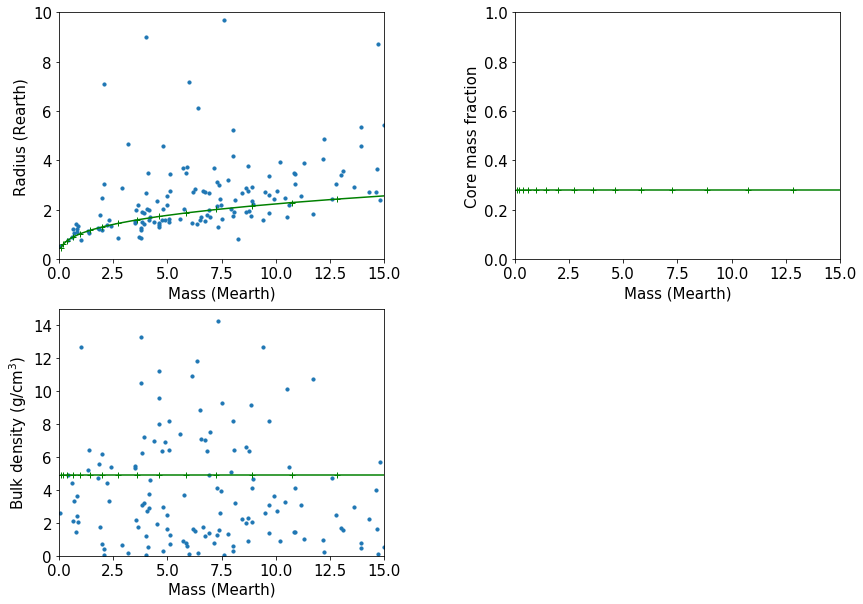

In [7]:
# Make mass-radius diagram with nonsense initialized planets

NR=1000 # number of radial layers
NP=20 # number of planets
planetradiusarr = np.linspace(3000,20000,NP) # in km
coreradiusarr = np.linspace(1500,10000,NP) # in km # just make half for now

planetmassarr = np.zeros(NP)
coremassarr = np.zeros(NP)
for ip in np.arange(NP):
    MYPLANET = PLANETclass()
    MYPLANET.makeinit(NR,planetradiusarr[ip],coreradiusarr[ip])
    planetmassarr[ip] = MYPLANET.M
    coremassarr[ip] = MYPLANET.Mcore
    #print(ip,MYPLANET.M/Mearth, MYPLANET.Mcore/MYPLANET.M)
densityarr = 1.e3*planetmassarr/(4./3.*3.14159*pow(1.e5*planetradiusarr,3))



# make 2 plots to show the different variables in the structure
fig, ([ax0, ax1],[ax2, ax3])= plt.subplots(ncols=2,nrows=2,figsize=(14,10))
plt.subplots_adjust(wspace=0.4)

ax0.scatter(Exoplanets[:,1],Exoplanets[:,2],s=10,marker='o')
ax0.plot(planetmassarr/Mearth,planetradiusarr*1000./Rearth,'g+-')
ax0.set_ylim(0.,10)
ax0.set_xlim(0.,15.)
ax0.set_xlabel('Mass (Mearth)',size=sfont)
ax0.set_ylabel('Radius (Rearth)',size=sfont)
ax0.tick_params(labelsize=sfont)
#ax0.legend(fontsize=sfont-5)

ax1.plot(planetmassarr/Mearth,coremassarr/planetmassarr,'g+-')
ax1.set_xlim(0.,15)
ax1.set_ylim(0,1.)
ax1.set_xlabel('Mass (Mearth)',size=sfont)
ax1.set_ylabel('Core mass fraction',size=sfont)
ax1.tick_params(labelsize=sfont)
#ax1.legend(fontsize=sfont-5)

ax2.plot(planetmassarr/Mearth,densityarr,'g+-')
ax2.scatter(Exoplanets[:,1],Exoplanets[:,0],s=10,marker='o')
ax2.set_xlim(0.,15)
ax2.set_ylim(0,15.)
ax2.set_xlabel('Mass (Mearth)',size=sfont)
ax2.set_ylabel('Bulk density (g/cm$^3$)',size=sfont)
ax2.tick_params(labelsize=sfont)
#ax1.legend(fontsize=sfont-5)

ax3.axis('off')

# Part 2: Murnaghan Isentropic Equation of State

From Wikipedia:<p>
<img src="./Murnaghan.png" width=800>
    
In Lab 05, you calculated the isentropic bulk modulus profile of Earth using PREM and fit K(P) lines through the lower mantle and core.<p>

The temperature profile is given by the adiabatic temperature gradient:<br>
    $\frac{dT}{dz} = \frac{\alpha g T}{c_p}$<p>
    
Let's use these fits for our Murnaghan EOS:<br>
dKdP and K0 for lower mantle and core<br>
[3.23628926e+00 2.28137605e+11] (lower mantle)<br>
[3.42253778e+00 1.79997961e+11] (outer core)<p>


<img src="./PREM-fits.png" width=500>



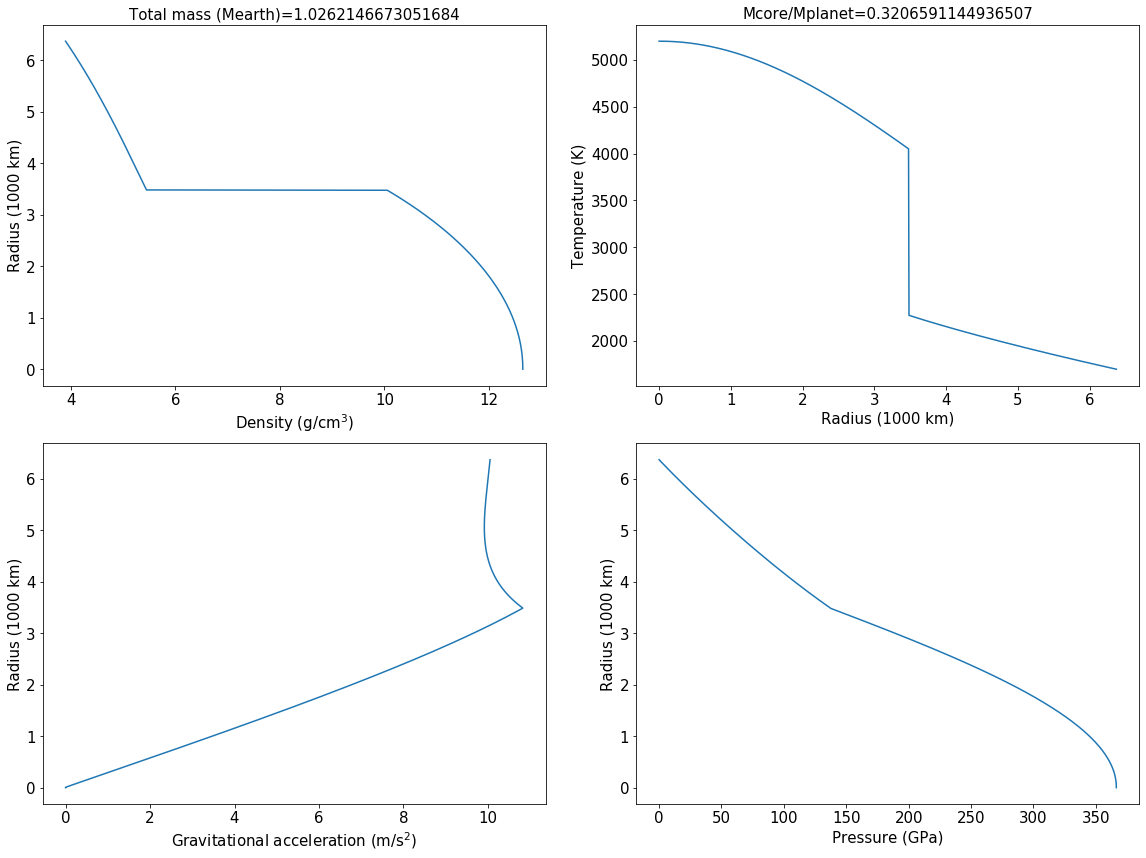

In [8]:
# Make mass-radius diagram with Murnaghan EOS 2-layer planets
# From fits to PREM profile in Lab 05:
# dKdP and K0 for lower mantle and core
#[3.23628926e+00 2.28137605e+11]
#[3.42253778e+00 1.79997961e+11]

# Murnaghan isentropic EOS parameters: [rho0,Ks0,dKsdP,T0] in [kg/m3, Pa, -, K]
EOSmantle = [3900.,2.28137605E11,3.23628926,1700.] # rho0 is mantle silicate at zero pressure
EOScore = [6900.,1.79997961E11,3.42253778,4050.] # rho0 is liquid iron at zero pressure

# Now try to initialize an Earth-like planet
MYPLANET = PLANETclass()
MYPLANET.makeinit(1000,Rearth/1000.,Rcmb/1000.) # input radii are in km
MYPLANET.MurnaghanEOS(EOSmantle,EOScore)
MYPLANET.plotplanet()

## What is the temperature profile in the Earth?

The Earth\'s surface is about 300 K but the mantle adiabat is much warmer. 
The temperature at the intersection of the mantle adiabat with 1 bar pressure is called the mantle\'s potential 
temperature. The potential temperature is about 1410 degrees C.<p>

The core temperature is not known and is estimated by modeling the thermal structure of the Earth. 
Here is a recent estimate from Anzellini et al., Science, 2013, where the temperature of iron alloy at the core-mantle boundary is about 4050 K:<br>
<img src="./coretemp.png" width="600" >


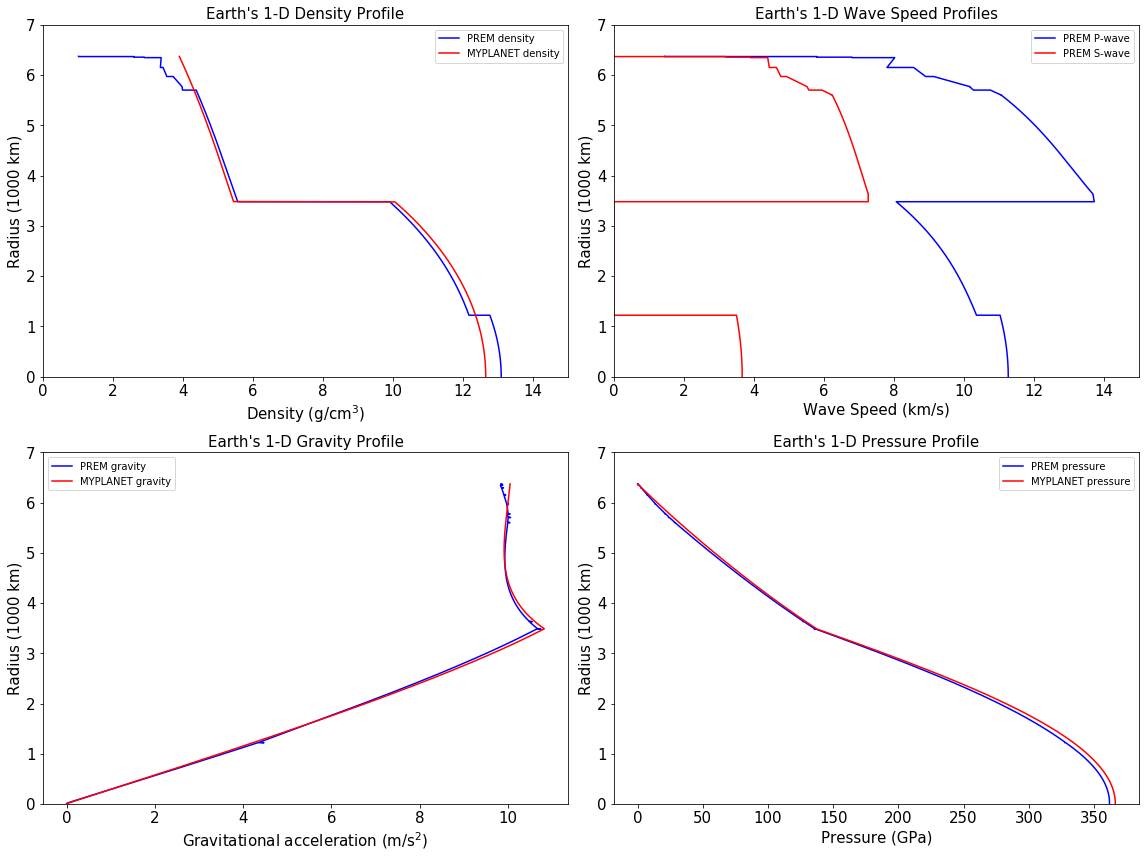

In [9]:
# Compare this Earth-like planet to PREM

# Now let's make some plots of the planet
sfont=15 # I like to set the size of my fonts

# make 4 plots to show the different variables in the structure
fig, ([ax0, ax1], [ax2, ax3])= plt.subplots(ncols=2,nrows=2,figsize=(16,12))
plt.subplots_adjust(wspace=0.4)

# first subplot: density vs. radius
# change units to g/cm3 and 1000 km
ax0.plot(PREM.density/1.E3,PREM.radius/1.E6,'-',color='blue',label='PREM density')
ax0.plot(MYPLANET.density/1.E3,MYPLANET.radius/1.E6,'-',color='red',label='MYPLANET density')
ax0.set_ylim(0.,7)
ax0.set_xlim(0,15.)
ax0.set_xlabel('Density (g/cm$^3$)',size=sfont)
ax0.set_ylabel('Radius (1000 km)',size=sfont)
ax0.set_title('Earth\'s 1-D Density Profile',size=sfont)
ax0.tick_params(labelsize=sfont)
ax0.legend(fontsize=sfont-5)

# second subplot: p-wave, s-wave vels vs. radius
# change units to km/s and 1000 km
ax1.plot(PREM.pwavevel/1.E3,PREM.radius/1.E6,'-',color='blue',label='PREM P-wave')
ax1.plot(PREM.swavevel/1.E3,PREM.radius/1.E6,'-',color='red',label='PREM S-wave')
ax1.set_ylim(0.,7)
ax1.set_xlim(0,15.)
ax1.set_xlabel('Wave Speed (km/s)',size=sfont)
ax1.set_ylabel('Radius (1000 km)',size=sfont)
ax1.set_title('Earth\'s 1-D Wave Speed Profiles',size=sfont)
ax1.tick_params(labelsize=sfont)
ax1.legend(fontsize=sfont-5)

# third subplot: gravitational acceleration vs. radius
# change units to 1000 km
ax2.plot(PREM.gravity,PREM.radius/1.E6,'-',color='blue',label='PREM gravity')
ax2.plot(MYPLANET.gravity,MYPLANET.radius/1.E6,'-',color='red',label='MYPLANET gravity')
ax2.set_ylim(0.,7)
ax2.set_xlabel('Gravitational acceleration (m/s$^2$)',size=sfont)
ax2.set_ylabel('Radius (1000 km)',size=sfont)
ax2.set_title('Earth\'s 1-D Gravity Profile',size=sfont)
ax2.tick_params(labelsize=sfont)
ax2.legend(fontsize=sfont-5)

# fourth subplot: pressure vs. radius
# change units to GPa and 1000 km
ax3.plot(PREM.pressure/1.e9,PREM.radius/1.E6,'-',color='blue',label='PREM pressure')
ax3.plot(MYPLANET.pressure/1.e9,MYPLANET.radius/1.E6,'-',color='red',label='MYPLANET pressure')
ax3.set_ylim(0.,7)
ax3.set_xlabel('Pressure (GPa)',size=sfont)
ax3.set_ylabel('Radius (1000 km)',size=sfont)
ax3.set_title('Earth\'s 1-D Pressure Profile',size=sfont)
ax3.tick_params(labelsize=sfont)
ax3.legend(fontsize=sfont-5)


# this command adjusts the white space around the plots
plt.tight_layout(pad=1.,w_pad=1.,h_pad=1.0)

# this saves a pdf file -- vector graphics are preferred
#plt.savefig('MYPLANET-plot.pdf', format='pdf', dpi=300,transparent=True)

# this is saving a png file -- raster graphics need to be very high resolution for crisp text
#plt.savefig('MYPLANET-plot.png', format='png', dpi=300,transparent=False)




## Make Mass-Radius plot using Murnaghan EOS

Planet Masses (Mearth) =  [8.55143975e-02 1.93930541e-01 3.77032081e-01 6.63776816e-01
 1.09187889e+00 1.70867329e+00 2.57309123e+00 3.75709128e+00
 5.34439184e+00 7.44093041e+00 1.01618744e+01 1.36353525e+01
 1.80239208e+01 2.34810377e+01 3.01981099e+01 3.84036079e+01
 4.82847388e+01 6.01010794e+01 7.41170788e+01 9.06767184e+01]
Core Mass fraction =  [0.21647649 0.22566631 0.23605202 0.24675136 0.25749582 0.26772085
 0.27706298 0.28531686 0.2923431  0.29831085 0.30321295 0.30713386
 0.31028547 0.31271987 0.31458695 0.31601256 0.3170334  0.3177458
 0.31820917 0.31848287]


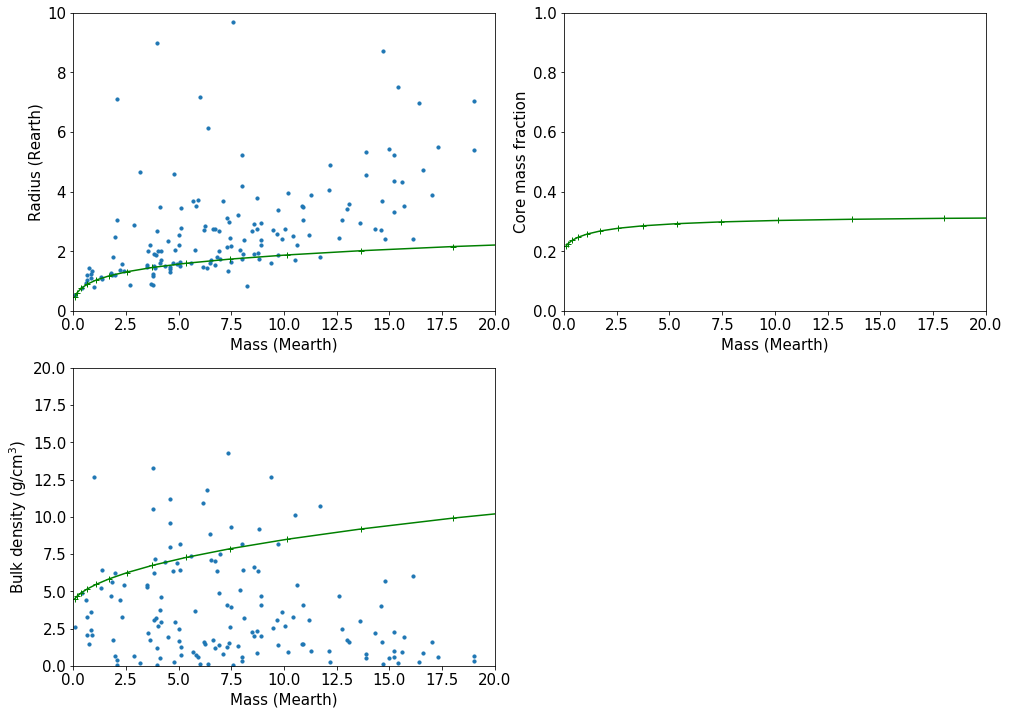

In [10]:
# Make mass-radius diagram with Murnaghan EOS 2-layer planets
# From fits to PREM profile in Lab 05:
# dKdP and K0 for lower mantle and core
#[3.23628926e+00 2.28137605e+11]
#[3.42253778e+00 1.79997961e+11]

# Murnaghan isentropic EOS parameters: [rho0,Ks0,dKsdP,T0] in [kg/m3, Pa, -, K]
EOSmantle = [3900.,2.28137605E11,3.23628926,1700.]
EOScore = [6900.,1.79997961E11,3.42253778,4500.]

NR=1000
NP=20 # number of planets
planetradiusarr = np.linspace(3000,20000,NP) # in km
coreradiusarr = np.linspace(1500,10000,NP) # in km # just make half for now
#coreradiusarr = planetradiusarr*0.05
#coreradiusarr = planetradiusarr*0.95



planetmassarr = np.zeros(NP)
coremassarr = np.zeros(NP)
for ip in np.arange(NP):
    MYPLANET = PLANETclass()
    MYPLANET.makeinit(NR,planetradiusarr[ip],coreradiusarr[ip])
    MYPLANET.MurnaghanEOS(EOSmantle,EOScore)
    planetmassarr[ip] = MYPLANET.M
    coremassarr[ip] = MYPLANET.Mcore
    #print(ip,MYPLANET.M/Mearth, MYPLANET.Mcore/MYPLANET.M)
densityarr = 1.e3*planetmassarr/(4./3.*3.14159*pow(1.e5*planetradiusarr,3))
print('Planet Masses (Mearth) = ',planetmassarr/Mearth)
print('Core Mass fraction = ',coremassarr/planetmassarr)


# make 2 plots to show the different variables in the structure
fig, ([ax0, ax1],[ax2, ax3])= plt.subplots(ncols=2,nrows=2,figsize=(14,10))
plt.subplots_adjust(wspace=0.4)

ax0.scatter(Exoplanets[:,1],Exoplanets[:,2],s=10,marker='o')
ax0.plot(planetmassarr/Mearth,planetradiusarr*1000./Rearth,'g+-')
ax0.set_ylim(0.,10)
ax0.set_xlim(0.,20.)
ax0.set_xlabel('Mass (Mearth)',size=sfont)
ax0.set_ylabel('Radius (Rearth)',size=sfont)
ax0.tick_params(labelsize=sfont)
#ax0.legend(fontsize=sfont-5)

ax1.plot(planetmassarr/Mearth,coremassarr/planetmassarr,'g+-')
ax1.set_xlim(0.,20)
ax1.set_ylim(0,1.)
ax1.set_xlabel('Mass (Mearth)',size=sfont)
ax1.set_ylabel('Core mass fraction',size=sfont)
ax1.tick_params(labelsize=sfont)
#ax1.legend(fontsize=sfont-5)

ax2.plot(planetmassarr/Mearth,densityarr,'g+-')
ax2.scatter(Exoplanets[:,1],Exoplanets[:,0],s=10,marker='o')
ax2.set_xlim(0.,20)
ax2.set_ylim(0,20.)
ax2.set_xlabel('Mass (Mearth)',size=sfont)
ax2.set_ylabel('Bulk density (g/cm$^3$)',size=sfont)
ax2.tick_params(labelsize=sfont)
#ax1.legend(fontsize=sfont-5)

ax3.axis('off')

# this command adjusts the white space around the plots
plt.tight_layout(pad=1.,w_pad=1.,h_pad=1.0)
# this saves a pdf file -- vector graphics are preferred
plt.savefig('My-Mass-Radius-plot.pdf', format='pdf', dpi=300,transparent=True)



## Part 3: Mie-Gruneisen EOS

A P-V-T EOS model based on a third order Birch-Murnaghan isotherm plus a thermal pressure term using the thermal Gruneisen parameter. See equations 1-6 in Aizawa et al 2006:<p>

$P(V,T) = P(V,T_0) + P_{th}(V,T)$<p>
    
The first term is the isentrope, usually taken from ambient temperautre $T_0=300$ K. We will use the 3rd order Birch-Murnaghan equation:<br>
$P(V,T_0) = (3/2)K_{T0} [ (V/V_0)^{-7/3} - (V/V_0)^{-5/3} ] \times [ 1 + (3/4)(K'_T-4) [(V/V_0)^{-2/3} - 1 ] ]$<p>

The thermal Gruneisen parameter is assumed to only depend on volume:<br>
    $\gamma(V) = \gamma_0 (V/V_0)^q$<p>

The thermal pressure term is:<br>
    $P_{th}(V,T) = (\gamma(V)/V) \times (E(V,T) - E(V,T_0))$<br>
    $P_{th}(V,T) = 9nRT (\gamma/V) (T/\theta)^3 \int_0^{\theta/T} (z^3/(e^z-1)) dz$ (p122 in Sakai) <p>
   

Use the type 2 formulation in Sakai et al. 2014 Table 6 and 7 for pure Fe:<br>
$\theta(V) = \theta_0 exp((\gamma_0 - \gamma(V))/1)$<p>


## Homework:<br>
    1. Make a planet EOS function that uses the Mie-Gruneisen EOS for the mantle and core. Use the EOS parameters in the provided papers.<br>
    2. Draw a mass-radius diagram with the exoplanet data with three mass-radius curves for (1) pure Fe; (2) pure MgSiO3 perovskite; (3) two-layer Earth-like planet
    
    
Iron:<br>
    Use the Type 2 iron model: $\gamma_0=1.78$, q=0.69, $\theta_0=430$ K<br>
    $K_{T0}$=179.6 GPa, K'=4.91, V_0=22.18 A^3/unit cell (Z=2)<br>
    $\rho_0$=55.845 g/mole Fe x (1 mol/6.022e23 formula units of Fe)x(2 formula units/unit cell)(1 unit cell/22.18 A^3) = g/A^3 /1000*10^30 -> 8362 kg/m3    <p>
        
MgSiO$_3$ bridgmanite (Aizawa et al. 2006):<br>
    $K_{T0}$=261 GPa, K'=3.9, $\gamma_0=1.35$, q=1.2<br>
    $\theta_0=1000$K, $V_0$ = 162.3 A$^3$ (looks like Z=4 is correct)<br>
    $\rho_0$=(24.305+28.085+3x15.999) g/mole MgSiO3 x (1 mol/6.022e23 formula units of Fe)x(4 formula units/unit cell)(1 unit cell/162.3 A^3) = g/A^3 /1000*10^30 -> 4108.45 kg/m3 <p>
        
    
Using equations 1-6, write a function that returns P(V,T).<p>
    
Next cell has an example of how to generate a new density profile.<p>
  


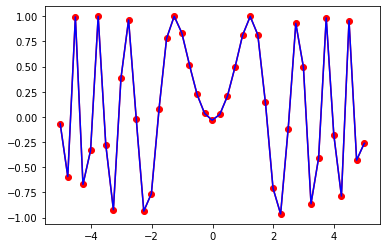

[175.751501 157.850176 141.733851 127.308776 114.481201 103.157376
  93.243551  84.645976  77.270901  71.024576  65.813251  61.543176
  58.120601  55.451776  53.442951  52.000376  51.030301  50.438976
  50.132651  50.017576  50.000001  49.986176  49.882351  49.594776
  49.029701  48.093376  46.692051  44.731976  42.119401  38.760576
  34.561751  29.429176  23.269101  15.987776   7.491451  -2.313624
 -13.521199 -26.225024 -40.518849 -56.496424 -74.251499] [-5.01 -4.76 -4.51 -4.26 -4.01 -3.76 -3.51 -3.26 -3.01 -2.76 -2.51 -2.26
 -2.01 -1.76 -1.51 -1.26 -1.01 -0.76 -0.51 -0.26 -0.01  0.24  0.49  0.74
  0.99  1.24  1.49  1.74  1.99  2.24  2.49  2.74  2.99  3.24  3.49  3.74
  3.99  4.24  4.49  4.74  4.99]
50.0 3.6810095282290036


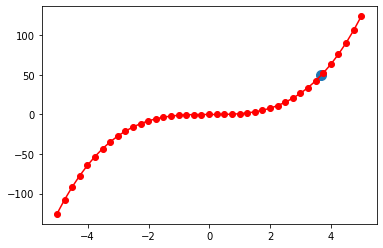

In [11]:
# Generic example using 2D interpolation
from scipy import interpolate
x = np.arange(-5.01, 5.01, 0.25)
y = np.arange(-5.01, 5.01, 0.25)
xx, yy = np.meshgrid(x, y)
z = np.sin(xx**2+yy**2)
f = interpolate.interp2d(x, y, z, kind='linear')

xnew = np.arange(-5.01, 5.01, 1e-2)
ynew = np.arange(-5.01, 5.01, 1e-2)
znew = f(xnew, ynew) # using the interpolate function generated above
plt.plot(x, z[0, :], 'ro-', xnew, znew[0, :], 'b-')
plt.show()

# Use 1D interpolation to find V at the new P for fixed T with a function of the form P(V,T):
V = np.arange(-5.01, 5.01, 0.25) # need to generate an array of densities around the desired value (could start with a range around the Murnaghan planet)
P = V**3 # at the fixed T (this replace with Mie Gruneisen EOS function)
P0 = 50. # we want the new V at P0 at the fixed T
Pfindzero = P0-P
f = interpolate.interp1d(Pfindzero,V, kind='linear') # now made Pfix the independent variable and V the output

print(Pfindzero,V)
Vnew = f(0) # using the 1d interpolation function generated above find the desired point, where Pfindzero=0
print(P0,Vnew)

# the pressure, gravity profiles are recalculated with the new densities
# The temperature profile would be updated with the new gravity profile
# repeat until convergence

plt.plot(V, P, 'ro-')
plt.scatter(Vnew, P0, s=100) # blue dot shows the desired Vnew value at P0
plt.show()



V0 for iron = 6.6786e-06 m^3/mol, V0 for pv = 2.4435e-05 m^3/mol


Text(0, 0.5, 'Density $(g/cm^3)$')

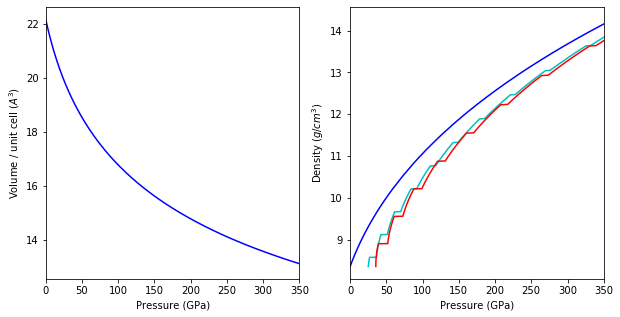

In [106]:
GPa = 1e9  # Gpa to Pa
A3 = 1e-30  # A3 to m3
g_per_cm3 = 1e3  # g/cm^3 to kg/m^3

class PVT():
    '''
    class for a equation of state
    Attributes:
        todo
    
    '''
    
    def __init__(self, _k_T0, _k_dot, _gamma0, _q, _theta0, _rho0, _V0, _T0):
        '''
        init
        Args:
            todo
        '''
        self.k_T0 = _k_T0
        self.k_dot = _k_dot
        self.gamma0 = _gamma0
        self.q = _q
        self.theta0 = _theta0
        self.rho0 = _rho0
        self.V0 = _V0
        self.T0 = _T0
        self.Pth0 = self.pressure_th(1.0, _T0)  # get the reference value for Pth0
        
    def pressure(self, _ratio, _T, **kwargs):
        '''
        P(V, T)
        
        Args:
            _ratio: V/V0
            _T(K) : temperature
            
        Returns:
            P(Pa) : pressure
        '''
        _interval = kwargs.get('interval', 0.01)  # interval for integration, default is 0.01
        _P = self.pressure_T0(_ratio) + self.pressure_th(_ratio, _T, interval=_interval) - self.Pth0
        return _P
        
    def pressure_th(self, _ratio, _T, **kwargs):
        '''
        Pth
        
        Args:
            _ratio: V/V0
            _T(K) : temperature
            
        Return:
            _Pth(Pa) : todo
        '''
        R = 8.314 # gas constant J/(mol*K)
        _interval = kwargs.get('interval', 0.01)  # interval for integration, default is 0.01
        _Vm = _ratio * self.V0  # molar volume
        _integral = self.integral1(_ratio, _T, interval=_interval)[0]
        _Pth = 9 * R * _T * self.gamma(_ratio) / _Vm * (_T / self.theta(_ratio))**3.0 * _integral
        return _Pth
    
    def pressure_T0(self, _ratio):
        '''
        P(V, T0)

        Args:
            _ratio: V/V0
        
        Returns:
            _P_T0(Pa) : todo
        '''
        _P_T0 = 3.0 / 2.0 * self.k_T0 * (_ratio**(-7.0/3.0) - _ratio**(-5.0/3.0)) * (1 + (3.0/4.0) * (self.k_dot - 4.0) * (_ratio**(-2.0/3.0) - 1.0))
        return _P_T0        
    
    def gamma(self, _ratio):
        '''
        get gamma value
        
        Args:
            _ration : V/V0
        '''
        return self.gamma0 * _ratio ** self.q
    
    def theta(self, _ratio):
        '''get theta value
        
        Args:
            _ratio: V/V0
        '''
        _exponent = (self.gamma0 - self.gamma(_ratio)) / self.q
        return self.theta0 * np.exp(_exponent)
    
    def integral1(self, _ratio, _T, **kwargs):
        '''
        compute the integral inside Pth
        
        Args:
            _ratio: V/V0
            _T(K) : temperature
        
        Returns:
            _integral: result
            _error_for_big_value
        '''
        _tiny = 1e-6
        _interval = kwargs.get('interval', 0.01)  # interval for integral, default is 0.01
        _lim = 1e-3  # lower limit for _theta/_T
        _lim1 = 25.0  # upper limit for _theta/_T
        _theta = self.theta(_ratio)
        
        if (_theta / _T) > (_lim1 + _tiny):
            _integral, _error_for_big_value = self.integral1(_ratio, _theta / _lim1)  # return the integral to the upper limit if _theta/_T is too big
            _error_for_big_value = self.integral1_error_for_big_value(_lim1)
            return _integral, _error_for_big_value
        
        _z = np.arange(0.0, _theta/_T, _interval)
        _mask = (_z < _lim)
        _mask_normal = (~_mask)
        _fz = np.zeros(_z.size)
        _fz[_mask] = _z[_mask]  # when z is small, take an approximate form
        _fz[_mask_normal] = _z[_mask_normal]**3.0 / (np.exp(_z[_mask_normal]) - 1.0)
        return np.trapz(_fz, _z), 0.0  # no big value include, thus the error is zero
    
    def integral1_error_for_big_value(self, _z0):
        '''
        upper bound for error of cutoff of bigger value in integral1
        
        Args:
            _z0 : cut off value
        
        returns:
            error
        '''
        _x0 = 1 / _z0
        _error = (_x0**(-4)/(np.exp(1.0/_x0)-1))
        return _error
      
# convert V0
N0 = 6.02214076e23
V0_iron_cell = 22.18e-30  # V0, A^3 / cell
Z_iron = 2
V0_iron = V0_iron_cell * N0 / Z_iron  # V0, m^3 / mol
V0_pv_cell = 162.3e-30  # V0, A^3 / cell
rho0_iron = 8362.0  # density at 300k, 0Pa, kg/m^3
Z_pv = 4
V0_pv = V0_pv_cell * N0 / Z_pv  # V0, m^3 / mol
print("V0 for iron = %.4e m^3/mol, V0 for pv = %.4e m^3/mol" % (V0_iron, V0_pv))

IronPvt = PVT(179.6e9, 4.91, 1.78, 0.69, 430.0, 8362.0, V0_iron, 300.0)
PvPvt = PVT(261e9, 3.9, 1.35, 1.2, 1000.0, 4108.45, V0_pv, 300.0)
assert(abs((IronPvt.gamma(1.0) - 1.78)/1.78)<1e-6)  # test driven
assert(abs((IronPvt.theta(1.0) - 430.0)/430.0)<1e-6)
assert(abs(IronPvt.integral1(1.0, 1e6)[0])<1e-6)
assert(abs(IronPvt.pressure_T0(1.0))<1e-6)
assert(abs(IronPvt.pressure(1.0, 300.0))<1e-6)

fig = plt.figure(figsize=[10,5])
ax1 = fig.add_subplot(121)
ratio = np.linspace(1.0, 13e-30/V0_iron_cell, 1000)
P_300 = np.zeros(ratio.size)
P_5000 = np.zeros(ratio.size)
P_6000 = np.zeros(ratio.size)
for i in range(ratio.size):
    P_300[i] = IronPvt.pressure(ratio[i], 300.0)
    P_5000[i] = IronPvt.pressure(ratio[i], 5000.0)
    P_6000[i] = IronPvt.pressure(ratio[i], 6000.0)
ax1.plot(P_300/GPa, ratio*V0_iron_cell/A3, 'b')   # ratio at 300K, fig3a from Sakai-2014
ax1.set_xlim(0, 350)
ax1.set_xlabel('Pressure (GPa)')
ax1.set_ylabel('Volume / unit cell ($A^3$)')
ax2 = fig.add_subplot(122)
ax2.plot(P_300/GPa, rho0_iron/ratio/g_per_cm3, 'b', label='300 K')  # density, fig6a from Sakai-2014
ax2.plot(P_5000/GPa, rho0_iron/ratio/g_per_cm3, 'c', label='5000 K')
ax2.plot(P_6000/GPa, rho0_iron/ratio/g_per_cm3, 'r', label='6000 K')
ax2.set_xlim(0, 350)
ax2.set_xlabel('Pressure (GPa)')
ax2.set_ylabel('Density $(g/cm^3)$')

In [58]:
def test_function(x):
    return (x**(-4)/(np.exp(1.0/x)-1))
def test_function_1(x):
    return (x**(-3)/(np.exp(1.0/x)-1))
print(test_function(0.05))
print(test_function_1(0.04))

0.00032978458026990587
2.1699912289307646e-07


#END LAB 06